<a href="https://colab.research.google.com/github/german-cano/CTAO-image-processing-with-ants-algorithm/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LST DATA ANALYSIS
In this notebook I explore a portion of data from the first prototype os Large Scale Telescope from CTAO. The results obtained here will be used on the rest of datasets of this project.

In [ ]:
#lstchain: library from CTAO, used to process their data
%%capture
!pip install lstchain

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from ctapipe.io import read_table
from ctapipe.containers import EventType
from ctapipe import utils
from pkg_resources import resource_filename
from ctapipe.visualization import CameraDisplay
import os


import pandas as pd

plt.rc('font', size=12)

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#RAW DATA
filename = "/content/drive/MyDrive/TFG/dl1_LST-1.Run16581.0045.h5"


In [ ]:
#Here i save the data im interested in from the .h5 file.

#To plot the pixels
tablename = "/configuration/instrument/telescope/camera/geometry_0"
geo0 = read_table(filename, tablename)


# camera images:
tablename = "/dl1/event/telescope/image/LST_LSTCam"
camera = read_table(filename, tablename)

# parameters:
tablename = "/dl1/event/telescope/parameters/LST_LSTCam"
params = read_table(filename, tablename)

In [ ]:
#filter the final raw data we are interested in

imag_raw = camera['image'][:,:] #photoelectron charge registered at each pixel

temp_raw = camera['peak_time'][:,:] #Time when each pixel registered the data (ns)

mask = camera['image_mask'][:,:] #whether if the pixel value correspond to background noise


In [ ]:
#Here i save the position of each type of event

event = params['event_type']


ev0 = [i for i in range(event.shape[0]) if event[i] == 0] #flatfield

ev2 = [i for i in range(event.shape[0]) if event[i] == 2] #pedestal

ev32 = [i for i in range(event.shape[0]) if event[i] == 32] #cosmic

In [ ]:
len(ev0), len(ev2), len(ev32) #classes are unbalanced

(781, 774, 39528)

In [ ]:
#code used for handpicking more visual cosmic events for visualization
'''
max_cosmic =[]
max32 = []

for i in ev32:
  max_cosmic.append(max(imag_raw[i:i+1,:][0]))
  if max(imag_raw[i:i+1,:][0])>400 :
    max32.append(i)

'''

'\nmax_cosmic =[]\nmax32 = []\n\nfor i in ev32:\n  max_cosmic.append(max(imag_raw[i:i+1,:][0]))\n  if max(imag_raw[i:i+1,:][0])>400 :\n    max32.append(i)\n\n    '

In [ ]:
#Hand picked indices of visual cosmic events
cosm = [4720, 16054, 29169, 3753, 1654, 5733]

In [ ]:
#to visualize at least 6 plots of each event i create a list with the positions

pos = []

pos.append(ev0[500:506])
pos.append(ev2[500:506])
pos.append(cosm)

pos= np.array(pos).flatten()
pos

array([26597, 26662, 26706, 26756, 26801, 26860, 26667, 26714, 26764,
       26807, 26868, 26916,  4720, 16054, 29169,  3753,  1654,  5733])

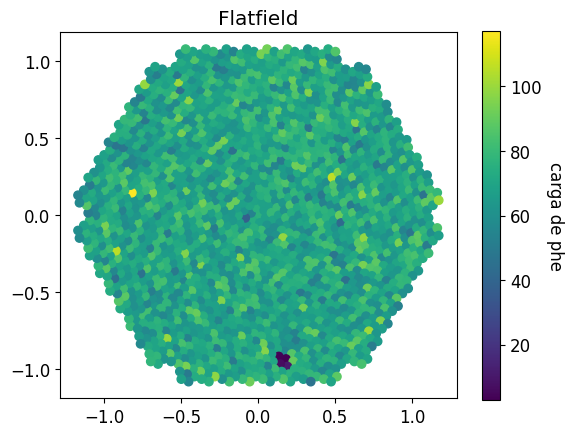

In [ ]:
#Interactive plot where the three different types of events, flatfield, pedestal and cosmic are displayed
#Pedestal: Runned by the CTAO team, controlled measure with an artificial light emission. Calibration purposes
#Flatfield: Background noise
#Cosmic: Either gamma rays or Cosmic rays

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

fig, ax = plt.subplots()

def animate(i):

    fig.clear()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=True)
    plot = ax.scatter(geo0['pix_x'],geo0['pix_y'], c = imag_raw[i:i+1,:] )
#    fig.colorbar(plot)
    a = plt.colorbar(plot)
    a.ax.set_ylabel('carga de phe', rotation=270, labelpad = 16.)

    if i in ev0:
      plt.title('Flatfield')
    elif i in ev32:
      plt.title('Cosmic')

    elif i in ev2:
      plt.title('Pedestals')

    return plot

ani = FuncAnimation(fig, animate, frames= pos, interval=800)

display(HTML(ani.to_jshtml()))

#ani.save('events.gif', writer='Pillow', fps=0.7)


#The second plot displayed under the video is because of google colab

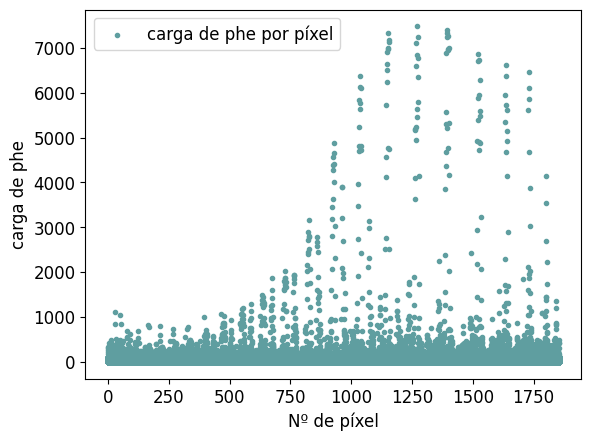

In [ ]:
#¡¡¡¡¡¡¡¡¡¡¡¡¡ DO NOT RUN THIS CELL, IT TAKES A LOT OF TIME!!!!!!!!!!!
# I only run it to get the plot, for visualization purposes.
'''
fig, ax = plt.subplots()
xlen = np.arange(imag_raw[:1,:][0].shape[0])

ax.scatter(xlen, imag_raw[:1,:], color = 'cadetblue',
           label = 'carga de phe por píxel', marker='.')

for i in range(1, imag_raw.shape[0]):
  ax.scatter(xlen, imag_raw[i-1:i,:], color = 'cadetblue',
             marker = '.')

ax.legend(loc = 'upper left')
ax.set_xlabel('Nº de píxel', fontsize = 12)
ax.set_ylabel('carga de phe', fontsize = 12)
plt.savefig('/content/drive/MyDrive/TFG/fotonesxpixel.png' )

plt.show()
'''



As it can be seen, most of the data is gathered around 0, but some values are above 7000. Ploting all the data as a barplot would be visually inneficient. I will then represent only the first 100 values.

Text(0, 0.5, 'Conteo')

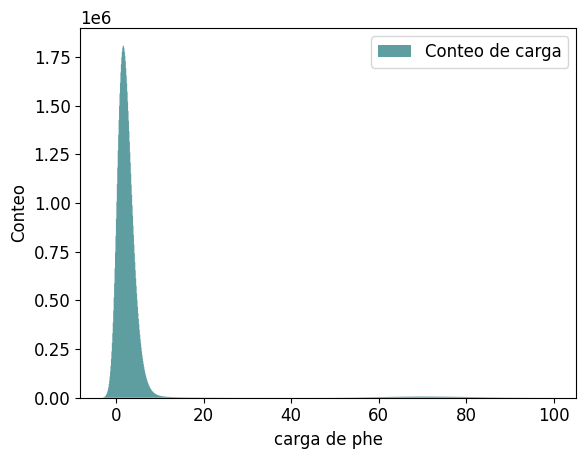

In [ ]:
#here we take a first look into how the data is distributed
raw = plt.hist(imag_raw[:,:].flatten(),bins=1000, range= [-3,100],
               histtype = 'stepfilled', color = 'cadetblue',
               label = 'Conteo de carga')

plt.legend()
plt.xlabel('carga de phe')
plt.ylabel('Conteo')
#plt.savefig('rawhist.png')

In [ ]:
#function to split the data between background noise and useful data, if we want to get just a specific event, pass a slice.
def splitdata(raw, msk, ev0 = ev0, ev32=ev32, ev2 = ev2):
  '''
  raw: phe charge data of each pixel
  msk: boolean, whether if pixel data is classified as noise
  ev0, ev2, ev32: positions of the different events in raw
  '''

  cosmic_clean_data = []
  flatfield_clean_data = []
  pedestal = []
  cosmicnoise =  []


  for i in ev2:
    for j in range(raw.shape[1]):
      pedestal.append(raw[i][j])

  for i in ev32:
    for j in range(raw.shape[1]):
      if msk[i][j]==False:
        cosmicnoise.append(raw[i][j])
      else:
        cosmic_clean_data.append(raw[i][j])

  for i in ev0:
    for j in range(raw.shape[1]):
      if msk[i][j]==False:
        pass
      else:
        flatfield_clean_data.append(raw[i][j])

  '''
  for i in range(raw.shape[0]):
    for j in range(raw.shape[1]):
      if msk[i][j] == False:
        aux.append(raw[i][j])
      else :
        if i in ev0:
          flatfield_clean_data.append(raw[i][j])
        elif i in ev32:
          cosmic_clean_data.append(raw[i][j])
      if i in ev2:
        pedestal.append(raw[i][j])
        '''
  return np.asarray(cosmicnoise), np.asarray(cosmic_clean_data), np.asarray(flatfield_clean_data),  np.asarray(pedestal)

In [ ]:
cosmnoise, cosmclean, flatclean, pedestal = splitdata(imag_raw, mask) # this takes a few minutes

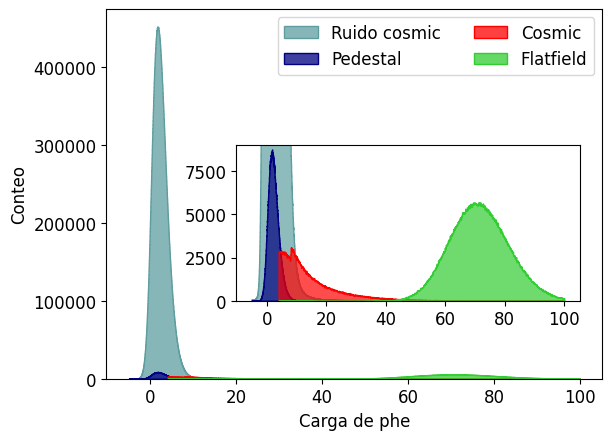

In [ ]:
#the background data is so abundant that it does not allow a correct representation of the rest
#here we zoom on the useful data to see how it looks

fig, ax = plt.subplots()

sns.histplot(cosmnoise, element = 'step', bins = 4000, binrange=(-5,100),
        color = 'cadetblue', label = 'Ruido cosmic', ax = ax, fill = True )

sns.histplot(pedestal, element = 'step', bins =600, binrange=(-5,10),
        color = 'navy', label = 'Pedestal', ax = ax, fill = True )

sns.histplot(cosmclean, element = 'step', bins = 1000, fill = True,
        binrange= (cosmclean.min(), 100), color = 'red' , label = 'Cosmic', ax=ax)

sns.histplot(flatclean, element = 'step', bins = 1000, fill = True,
        binrange= (flatclean.min(), 100), color = 'limegreen' , label = 'Flatfield', ax=ax)


axin1 = ax.inset_axes([20,100000,80,200000],
                      transform=ax.transData,  ylim=(0, 9000))

sns.histplot(cosmnoise, element = 'step', bins = 4000, binrange=(-5,100),
           color = 'cadetblue', label = 'Ruido cosmic', ax = axin1, fill=True, alpha=0.7 )

sns.histplot(pedestal, element = 'step', bins = 600, binrange=(-5,10),
           color = 'navy', label = 'Pedestal', ax = axin1, fill=True, alpha=0.7 )

sns.histplot(cosmclean, element = 'step', bins = 1000, fill = True,
           binrange= (cosmclean.min(), 100), color = 'red' , alpha = 0.7,
           label = 'Cosmic ', ax= axin1)

sns.histplot(flatclean, element = 'step', bins = 1000, fill= True,
           binrange= (flatclean.min(), 100), color = 'limegreen' , alpha = 0.7,
           label = 'Flatfield', ax = axin1)



axin1.set_ylabel('')

ax.legend(ncols = 2)
ax.set_xlabel('Carga de phe')
ax.set_ylabel('Conteo')
plt.savefig('splittedhist.png')

I have restricted the plot to a photoelectrons charge less than 100, let's see if that restriction is correct by calculating how much data I am letting out of the plot

Text(0, 0.5, 'Conteo')

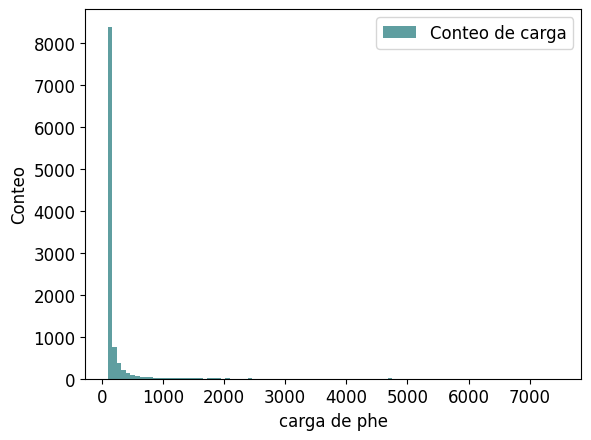

In [ ]:
raw2 = plt.hist(imag_raw[:,:].flatten(),bins=100,
               range= (100, max(imag_raw[:,:].flatten())),
               histtype = 'stepfilled',
               color = 'cadetblue',
               label = 'Conteo de carga')

plt.legend()
plt.xlabel('carga de phe')
plt.ylabel('Conteo')
#plt.savefig('rawhist2.png')

In [ ]:
raw2[0].sum() #not representative for visualization

10453.0

The amount of background noise data compared to the actual useful data is so dispair that we should find a way to express this noise as a simpler representation. For that purpose we first have a look at how the noise is distributed.

In [ ]:
#we are only interested in noise data, here I put it all on the same list
backgr = np.append(pedestal, cosmnoise)

Text(0, 0.5, 'Conteo')

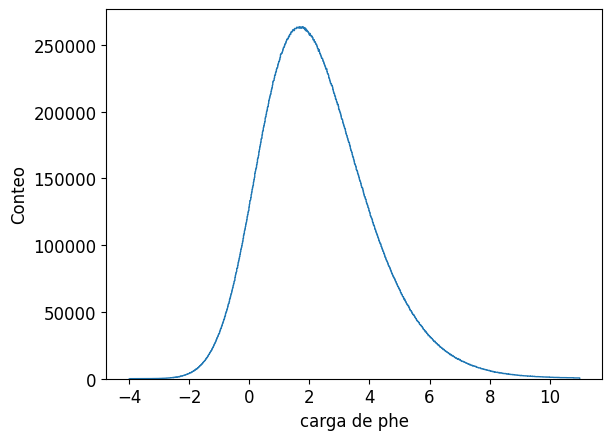

In [ ]:
#We are restricting the plot with the variable range
#that means that later we will only fit the noise to that range

hist = plt.hist(backgr, range =(-4, 11), histtype = 'step', bins = 1000)
plt.xlabel('carga de phe')
plt.ylabel('Conteo')


The data representation resemble a gaussian function, thus I will fit it with a gaussian and represent the noise as the $\sigma$ and $\mu$ of that function.

In [ ]:
import scipy as sp
from scipy import stats
from scipy.optimize import curve_fit

#Gauss fuction to fit the background data
def gauss(x, sigma, mu, C, D):
  return C*np.exp(-((x-mu)**2)/(2*sigma**2)) +D




In [ ]:
popt = curve_fit(gauss, xdata = hist[1][1:], ydata = hist[0], full_output = True
                )

In [ ]:
#the sum of 'fvec' values give us the chi^2 experimental value
chi2_exp = np.sum(popt[2]['fvec'])

#n= number of samples, p= fitted coefficients. n-p= degrees of freedom
n = len(hist[1][1:])
p = 4 # sigma, mu, C, D
chi2_reduced = chi2_exp/(n-p)

chi2_reduced #the fitting is good
chi2_exp

0.07412899564951658

In [ ]:
#covariance matrix
popt[1]

array([[ 7.13900591e-05,  2.30248519e-08, -2.07059543e+00,
        -2.51015070e+00],
       [ 2.30248519e-08,  4.89303823e-05,  1.92975498e-03,
        -2.64930705e-03],
       [-2.07059543e+00,  1.92975498e-03,  1.05103568e+06,
        -1.99125071e+05],
       [-2.51015070e+00, -2.64930705e-03, -1.99125071e+05,
         2.80569054e+05]])

In [ ]:
#parameters error
np.sqrt(np.diag(popt[1]))

array([8.44926382e-03, 6.99502554e-03, 1.02520031e+03, 5.29687695e+02])

In [ ]:
popt[0] # final value of fitted parameters

array([1.64229285e+00, 1.98229502e+00, 2.58572527e+05, 3.28315679e+03])

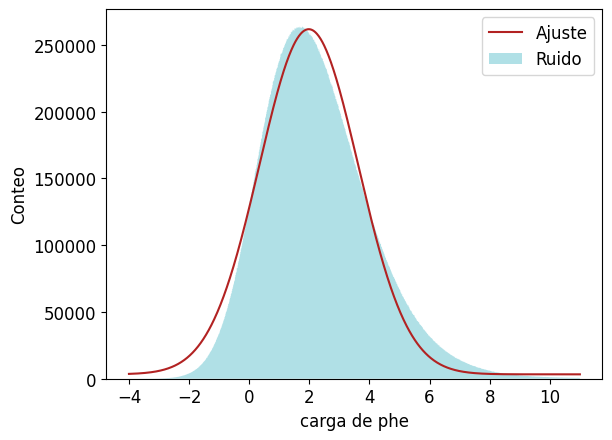

In [ ]:
plt.plot(hist[1], gauss(hist[1],*popt[0]), label = 'Ajuste', color = 'firebrick')
hist = plt.hist(backgr, range =(-4, 11), histtype = 'stepfilled', bins = 1000, label = 'Ruido', color = 'powderblue')


plt.legend()
plt.xlabel('carga de phe', fontsize = 12)
plt.ylabel('Conteo', fontsize = 12)


#plt.savefig('ajuste.png')

In [ ]:
#save all the data to use it on the other notebooks
np.savez('/content/drive/MyDrive/TFG/ctadata_raw', imag = imag_raw, temp = temp_raw, mask=mask, event = params['event_type']
         , bckgr_reduced = popt[0][:2], flatpos = ev0)